In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path

# class FixedUnpickler(pickle.Unpickler):
#     def find_class(self, module, name):
#         # Redirect PosixPath to WindowsPath
#         if module == 'pathlib' and name == 'PosixPath':
#             return WindowsPath
#         return super().find_class(module, name)

# def custom_load(file_path):
#     with open(file_path, 'rb') as f:
#         return FixedUnpickler(f).load()



if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda:0')  # Explicitly use the first GPU
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device('cpu')

# Your weights file
weights_path = 'yolov5/runs/train/card_number_detector_win2/weights/best.pt'

yolo_model = torch.hub.load('yolov5', 'custom', path=weights_path, source='local', force_reload=True, device=device)


CUDA is available!
Using device: NVIDIA GeForce RTX 3060 Laptop GPU


YOLOv5  2024-11-3 Python-3.12.3 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [12]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_classes=10, rnn_hidden_size=128):
        super(CRNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate feature height after 3 pooling layers
        self.feature_height = img_height // 8
        self.rnn_hidden_size = rnn_hidden_size
        
        # Bidirectional LSTM
        self.rnn = nn.LSTM(128 * self.feature_height, rnn_hidden_size, 
                           bidirectional=True, batch_first=True)
        
        # Final classification layer
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes + 1)  # +1 for CTC blank
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN Feature Extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Prepare for RNN
        x = x.permute(0, 3, 1, 2)  # (batch, width, channels, height)
        x = x.contiguous().view(batch_size, -1, 128 * self.feature_height)
        
        # RNN
        x, _ = self.rnn(x)
        
        # Final classification
        x = self.fc(x)  # Shape: (batch, seq_len, num_classes + 1)
        
        # Apply log softmax for CTC loss
        return F.log_softmax(x, dim=2)

# Instantiate the CRNN model
crnn_model = CRNN(img_height=64, num_classes=10)  # Adjust `img_height` to match your input image height
crnn_model.to(device)

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)

In [13]:
def train_hybrid_model(model, train_loader, val_loader, criterion, optimizer, 
                      num_epochs, device, scheduler=None):
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_char_acc': [], 'train_seq_acc': [],
        'val_loss': [], 'val_char_acc': [], 'val_seq_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_char_accuracies = []
        train_seq_accuracies = []
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Shape: (batch, seq_len, num_classes + 1)
            
            # Prepare CTC loss inputs
            batch_size = outputs.size(0)
            input_lengths = torch.full(size=(batch_size,), 
                                    fill_value=outputs.size(1), 
                                    dtype=torch.long,
                                    device=device)
            
            target_lengths = []
            target_labels = []
            for label in labels:
                valid_label = label[label != -1]  # Remove padding
                target_lengths.append(len(valid_label))
                target_labels.extend(valid_label.tolist())
            
            target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
            target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
            
            # CTC loss expects (seq_len, batch, num_classes)
            outputs = outputs.permute(1, 0, 2)
            
            # Calculate loss
            loss = criterion(outputs, target_labels, input_lengths, target_lengths)
            
            # Calculate accuracy
            predictions = decode_predictions(outputs)
            char_acc, seq_acc = calculate_accuracy(predictions, labels)
            
            # Update metrics
            running_loss += loss.item()
            train_char_accuracies.append(char_acc)
            train_seq_accuracies.append(seq_acc)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Char Acc: {char_acc:.4f}, '
                      f'Seq Acc: {seq_acc:.4f}')
        
        # Log training metrics for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_char_acc = sum(train_char_accuracies) / len(train_char_accuracies)
        epoch_train_seq_acc = sum(train_seq_accuracies) / len(train_seq_accuracies)
        history['train_loss'].append(epoch_train_loss)
        history['train_char_acc'].append(epoch_train_char_acc)
        history['train_seq_acc'].append(epoch_train_seq_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_char_accuracies = []
        val_seq_accuracies = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Prepare CTC loss inputs
                batch_size = outputs.size(0)
                input_lengths = torch.full(size=(batch_size,), 
                                        fill_value=outputs.size(1), 
                                        dtype=torch.long,
                                        device=device)
                
                target_lengths = []
                target_labels = []
                for label in labels:
                    valid_label = label[label != -1]  # Remove padding
                    target_lengths.append(len(valid_label))
                    target_labels.extend(valid_label.tolist())
                
                target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
                target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
                
                # CTC loss expects (seq_len, batch, num_classes)
                outputs = outputs.permute(1, 0, 2)
                
                # Calculate loss
                val_loss = criterion(outputs, target_labels, input_lengths, target_lengths)
                val_running_loss += val_loss.item()
                
                # Calculate accuracy
                predictions = decode_predictions(outputs)
                val_char_acc, val_seq_acc = calculate_accuracy(predictions, labels)
                val_char_accuracies.append(val_char_acc)
                val_seq_accuracies.append(val_seq_acc)
        
        # Log validation metrics for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_char_acc = sum(val_char_accuracies) / len(val_char_accuracies)
        epoch_val_seq_acc = sum(val_seq_accuracies) / len(val_seq_accuracies)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_char_acc'].append(epoch_val_char_acc)
        history['val_seq_acc'].append(epoch_val_seq_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Char Acc: {epoch_train_char_acc:.4f}, Train Seq Acc: {epoch_train_seq_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Char Acc: {epoch_val_char_acc:.4f}, Val Seq Acc: {epoch_val_seq_acc:.4f}')
        
        # Checkpoint the best model
        if epoch_val_seq_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_seq_acc
            best_model_wts = model.state_dict()
        
        # Step the scheduler if provided
        if scheduler:
            scheduler.step()
    
    model.load_state_dict(best_model_wts)
    return history

In [ ]:
# Update the DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn =custom_collate_fn)


# # Initialize the hybrid model
# img_height = 64  # Based on the transform resize height
# hybrid_model = HybridOCR(digit_cnn=digit_cnn, img_height=img_height).to(device)

# Initialize CTC loss
criterion = nn.CTCLoss(blank=10, reduction='mean')

# Initialize optimizer with learning rate scheduling
initial_lr = 0.001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, crnn_model.parameters()), 
                      lr=initial_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, 
                             verbose=True, min_lr=0.001)

# Training configuration
num_epochs = 100
best_val_accuracy = 0.0

print("Starting training...")
print(f"Training device: {device}")
print(f"Initial learning rate: {initial_lr}")
print(f"Number of epochs: {num_epochs}")

# Start training
history = train_hybrid_model(
    model=crnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    scheduler=None
)

c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Starting training...
Training device: cuda:0
Initial learning rate: 0.001
Number of epochs: 100


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/224.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/220.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/204.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/255.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

Epoch [1/100], Batch [0/12], Loss: 6.8361, Char Acc: 0.0446, Seq Acc: 0.0000


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/245.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/248.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/278.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/227.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/277.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/63.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/296.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/207.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/221.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/187.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/17.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/140.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/230.jpg, using full image
No detection found for APS360_Project_Dataset/dataset5/img/2.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

No detection found for APS360_Project_Dataset/dataset5/img/263.jpg, using full image


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning:

KeyboardInterrupt: 

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)


True
11.8
2.5.1+cu118


In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline


# # Function to display images in a grid
# def show_images(images, labels, n_cols=4):
#     n_images = len(images)
#     n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    
#     plt.figure(figsize=(3, n_rows * 3))
    
#     for idx in range(n_images):
#         plt.subplot(n_rows, n_cols, idx + 1)
#         plt.imshow(images[idx].permute(1, 2, 0), cmap='gray')  # Convert to (H, W, C) format
#         plt.title(f'Label: {labels[idx]}')
#         plt.axis('off')  # Hide axes
        
#     plt.tight_layout()
#     plt.show()
# # 
# # Iterate through the train_loader to collect all images
# all_images = []
# all_labels = []

# for inputs, targets in train_loader:
#     all_images.extend(inputs)  # Extend the list with the batch of images
#     all_labels.extend(targets.numpy())  # Extend the list with the batch of labels

# # Show all images in the training set
# show_images(all_images, all_labels, n_cols=1)

c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


YOLO Predictions: [tensor([[ 52.71741, 179.85004, 423.42892, 220.72134,   0.73689,   0.00000]], device='cuda:0')]


c:\Users\Lione\Desktop\APS360\APS360_Project\yolov5\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


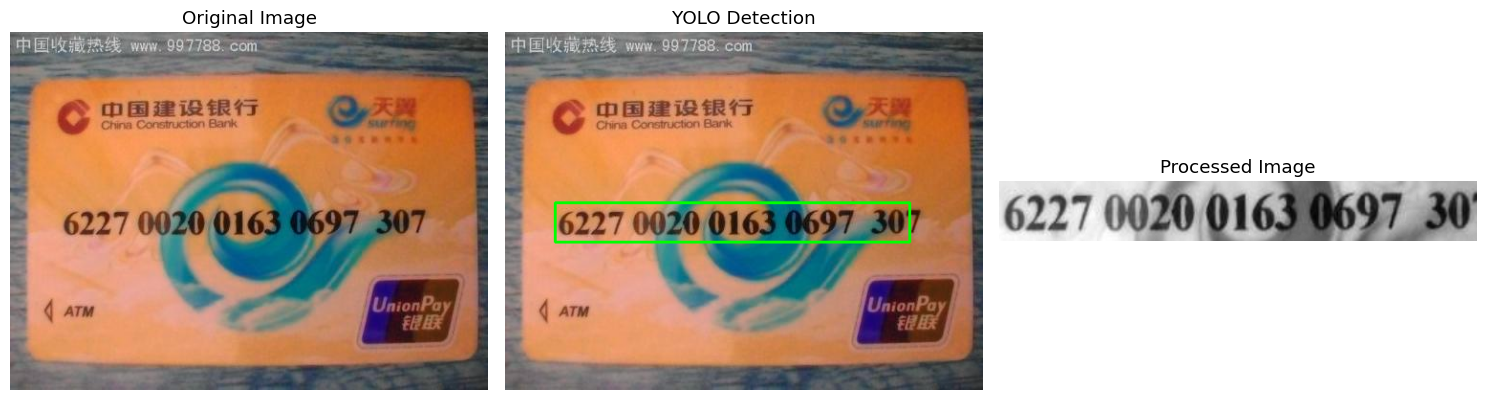

Label: 6227002001630697307


In [ ]:
def visualize_preprocessing(dataset, index):
    """
    Visualize the original image, YOLO detection, and final processed image
    """
    import matplotlib.pyplot as plt
    
    # Get original image path
    img_name = dataset.image_filenames[index]
    image_path = os.path.normpath(os.path.join(dataset.image_dir, img_name + '.jpg')).replace("\\", "/")
    
    # Read original image
    original_image = cv2.imread(image_path)
    
    # Get YOLO predictions
    results = dataset.yolo_model(original_image)
    print("YOLO Predictions:", results.xyxy)
    
    # Create a copy for drawing
    detection_image = original_image.copy()
    
    # Draw detection box
    if len(results.xyxy[0]) > 0:
        detection = results.xyxy[0][0]
        x1, y1, x2, y2 = map(int, detection[:4])
        cv2.rectangle(detection_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Get processed image
    processed_image, label = dataset[index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(detection_image)
    axes[1].set_title('YOLO Detection')
    axes[1].axis('off')
    
    # Convert tensor to numpy for visualization
    processed_np = processed_image.squeeze().numpy()
    axes[2].imshow(processed_np, cmap='gray')
    axes[2].set_title('Processed Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Label: {''.join(map(str, label.tolist()))}")
    
visualize_preprocessing(test_dataset,3)

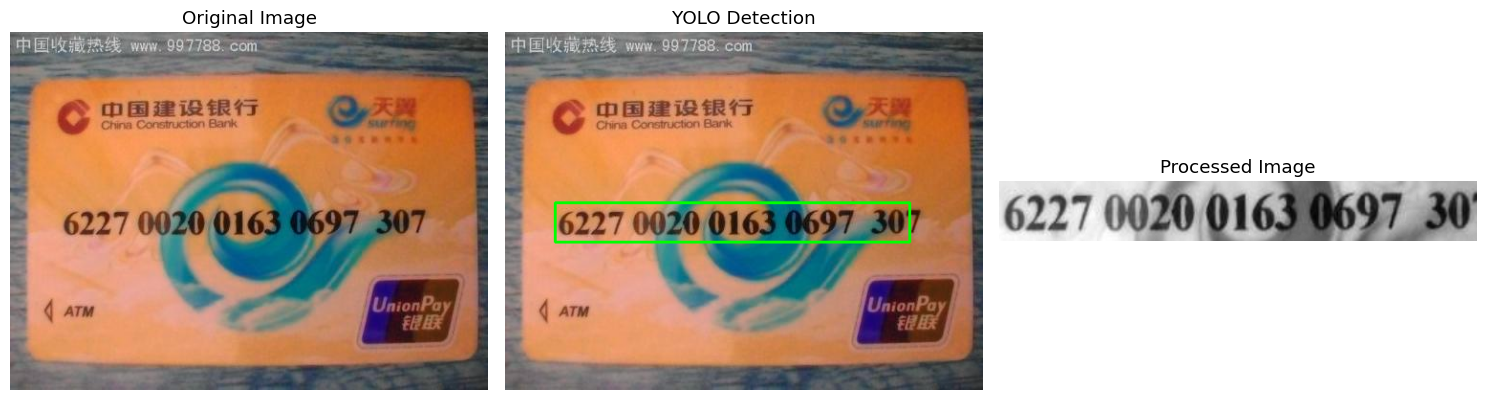

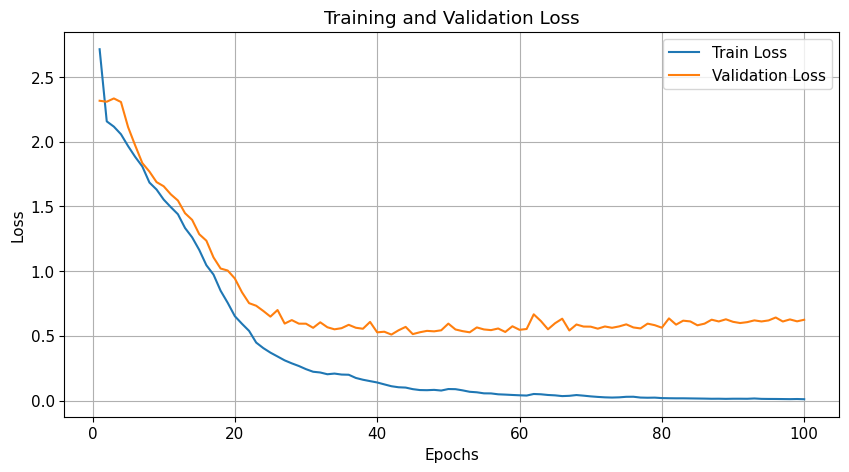

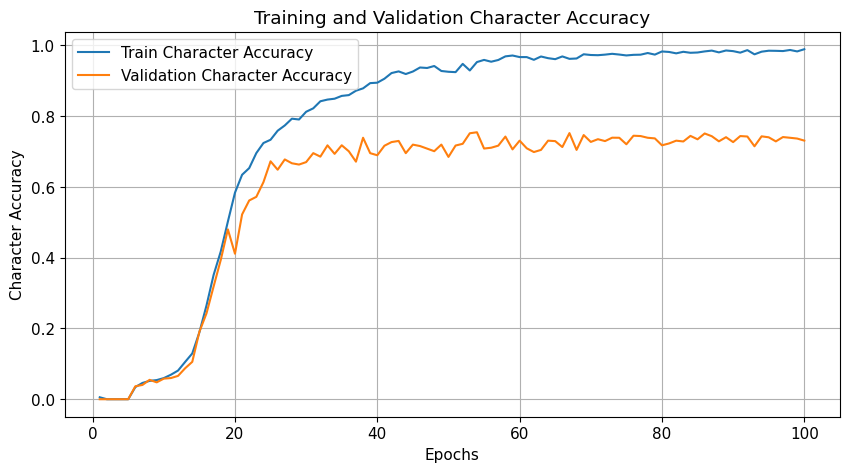

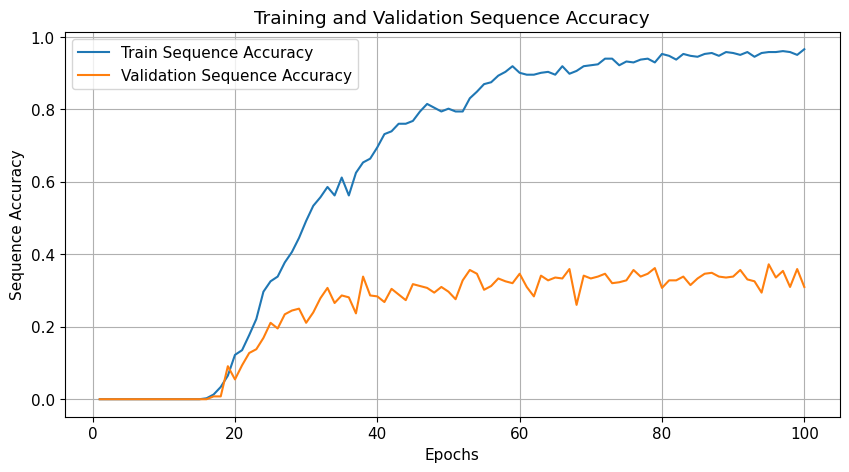

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    epochs = range(1, len(history['train_char_acc']) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_char_acc'], label='Train Character Accuracy')
    plt.plot(epochs, history['val_char_acc'], label='Validation Character Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Character Accuracy')
    plt.title('Training and Validation Character Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_seq_acc'], label='Train Sequence Accuracy')
    plt.plot(epochs, history['val_seq_acc'], label='Validation Sequence Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Sequence Accuracy')
    plt.title('Training and Validation Sequence Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_history(history)